In [9]:
import os
import sys
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multitest import multipletests
from sklearn.linear_model import LogisticRegression
import matplotlib.patches as mpatches
sys.path.append("/projects/b1198/epifluidlab/ravi/0130/headneck/scripts")
from loaders import HNSCCFeatureHandler

METADATA_PATH = "/projects/b1198/epifluidlab/ravi/0130/headneck/metadata/RAW_HNSCC_METADATA.csv"
VALID_IDS_PATH = "/projects/b1198/epifluidlab/ravi/0130/headneck/notebooks/lists/valid_ids.txt"
COVERAGE_DIR = '/projects/b1198/epifluidlab/ravi/0130/headneck/data/hg38_frag_filtered/*.hg38.frag.delfi.bed'
hc_data = HNSCCFeatureHandler(METADATA_PATH, VALID_IDS_PATH)
_ = hc_data.load_feature_to_dataframe("/projects/b1198/epifluidlab/ravi/0130/headneck/data/hg38_frag_filtered/*.hg38.frag.delfi.bed", 1, 11)
t = hc_data.normalize_zscore()
m = hc_data.merge_feature_metadata()

scaler=StandardScaler()
raw_data = hc_data.get_raw_features()
institute = hc_data.get_metadata_col("Institute")

X = raw_data
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)  
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df.index = X.index
pca_df['Institute'] = institute
pca_df['Institute'] = pca_df['Institute'] == 1
unique_institutes = pca_df['Institute'].unique()
colors = sns.color_palette("tab10", len(unique_institutes))
color_map = {institute: colors[i] for i, institute in enumerate(unique_institutes)}
clf = LogisticRegression()
clf.fit(pca_df[['PC1', 'PC2']], pca_df['Institute'])
decision_boundary_y = -(clf.coef_[0][0] * pca_df['PC1'] + clf.intercept_[0]) / clf.coef_[0][1]
pca_df['institute_corrected'] = pca_df['PC2'] > decision_boundary_y
hc_data.metadata['Institute_Corrected']=pca_df['institute_corrected']

raw_data = hc_data.get_raw_features()
pilot = hc_data.get_metadata_col("Pilot")

X = raw_data
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)  
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df.index = X.index
pca_df['Pilot'] = pilot
pca_df['Pilot'] = pca_df['Pilot'] == 1
unique_pilots = pca_df['Pilot'].unique()
colors = sns.color_palette("tab10", len(unique_pilots))
color_map = {pilot: colors[i] for i, pilot in enumerate(unique_pilots)}
clf = LogisticRegression()
clf.fit(pca_df[['PC1', 'PC2']], pca_df['Pilot'])
decision_boundary_y = -(clf.coef_[0][0] * pca_df['PC1'] + clf.intercept_[0]) / clf.coef_[0][1]
pca_df['pilot_corrected'] = pca_df['PC2'] > decision_boundary_y
hc_data.metadata['Pilot_Corrected']=pca_df['pilot_corrected']

hc_data.merge_feature_metadata()["Institute_Corrected"]
hc_data.batch_correct()
raw_data = hc_data.get_raw_features()
#_ = hc_data.normalize_zscore()

In [10]:
import matplotlib.patches as mpatches
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import pandas as pd

def plot_clustered_heatmap(df, path):
    chr_columns = [col for col in df.columns if col.startswith("chr")]
    df_features = df[chr_columns]
    metadata_columns = ['Response Rate', 'Treatment Response', 'Institute']
    row_metadata = df[metadata_columns]
    row_colors = pd.DataFrame(index=df.index)
    
    norm = plt.Normalize(vmin=0, vmax=100)
    cmap = sns.color_palette("Blues", as_cmap=True)
    response_rate_colors = cmap(norm(row_metadata["Response Rate"]))
    row_colors["Response Rate"] = [response_rate_colors[i] for i in range(len(response_rate_colors))]
    
    treatment_palette = {"Responder": "lightblue", "Non-Responder": "orchid"}
    row_colors["Treatment Response"] = row_metadata["Treatment Response"].map(treatment_palette)
    
    unique_institutes = row_metadata["Institute"].unique()
    institute_palette = dict(zip(unique_institutes, sns.color_palette("Set2", len(unique_institutes))))
    row_colors["Institute"] = row_metadata["Institute"].map(institute_palette)
    
    # Create the clustermap
    g = sns.clustermap(
        df_features,
        cmap="bwr",
        vmin=-2, vmax=2,
        row_cluster=True,
        col_cluster=True,
        figsize=(20, 16),
        dendrogram_ratio=(0.1, 0.1),
        row_colors=row_colors,
        cbar_pos=None,
        xticklabels=False
    )

    # Now manually adjust the layout using subplots
    fig = g.fig  # Get the figure from the sns.clustermap object
    # Adjust the figure to create enough space for colorbar
    fig.subplots_adjust(right=0.85)  # Move everything to the left slightly

    # Create a new axis for the colorbar (horizontal and thinner)
    cbar_ax = fig.add_axes([-0.04, 0.95, 0.1, 0.005])  # Adjust the position for a thin horizontal colorbar

    # Create a ScalarMappable for the colorbar
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Add the colorbar to the new axis
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
    cbar.set_label("Response Rate")
    
    # Adjust the Treatment Response legend
    treatment_patches = [mpatches.Patch(color=color, label=label) for label, color in treatment_palette.items()]
    legend2 = g.ax_heatmap.legend(
        handles=treatment_patches,
        title="Treatment Response",
        bbox_to_anchor=(-0.125, 1.05),  # Move legend to the top right
        loc='center left'
    )
    #plt.tight_layout()
    plt.savefig(path)
    plt.show()


In [11]:
SCREEN_PATH = '/projects/b1198/epifluidlab/ravi/0130/headneck/notebooks/figures/coverage/cov_screen.tsv'
SCREEN_DATA = hc_data.get_subset(hc_data.screen_ids, df=hc_data.filter_locations(SCREEN_PATH))

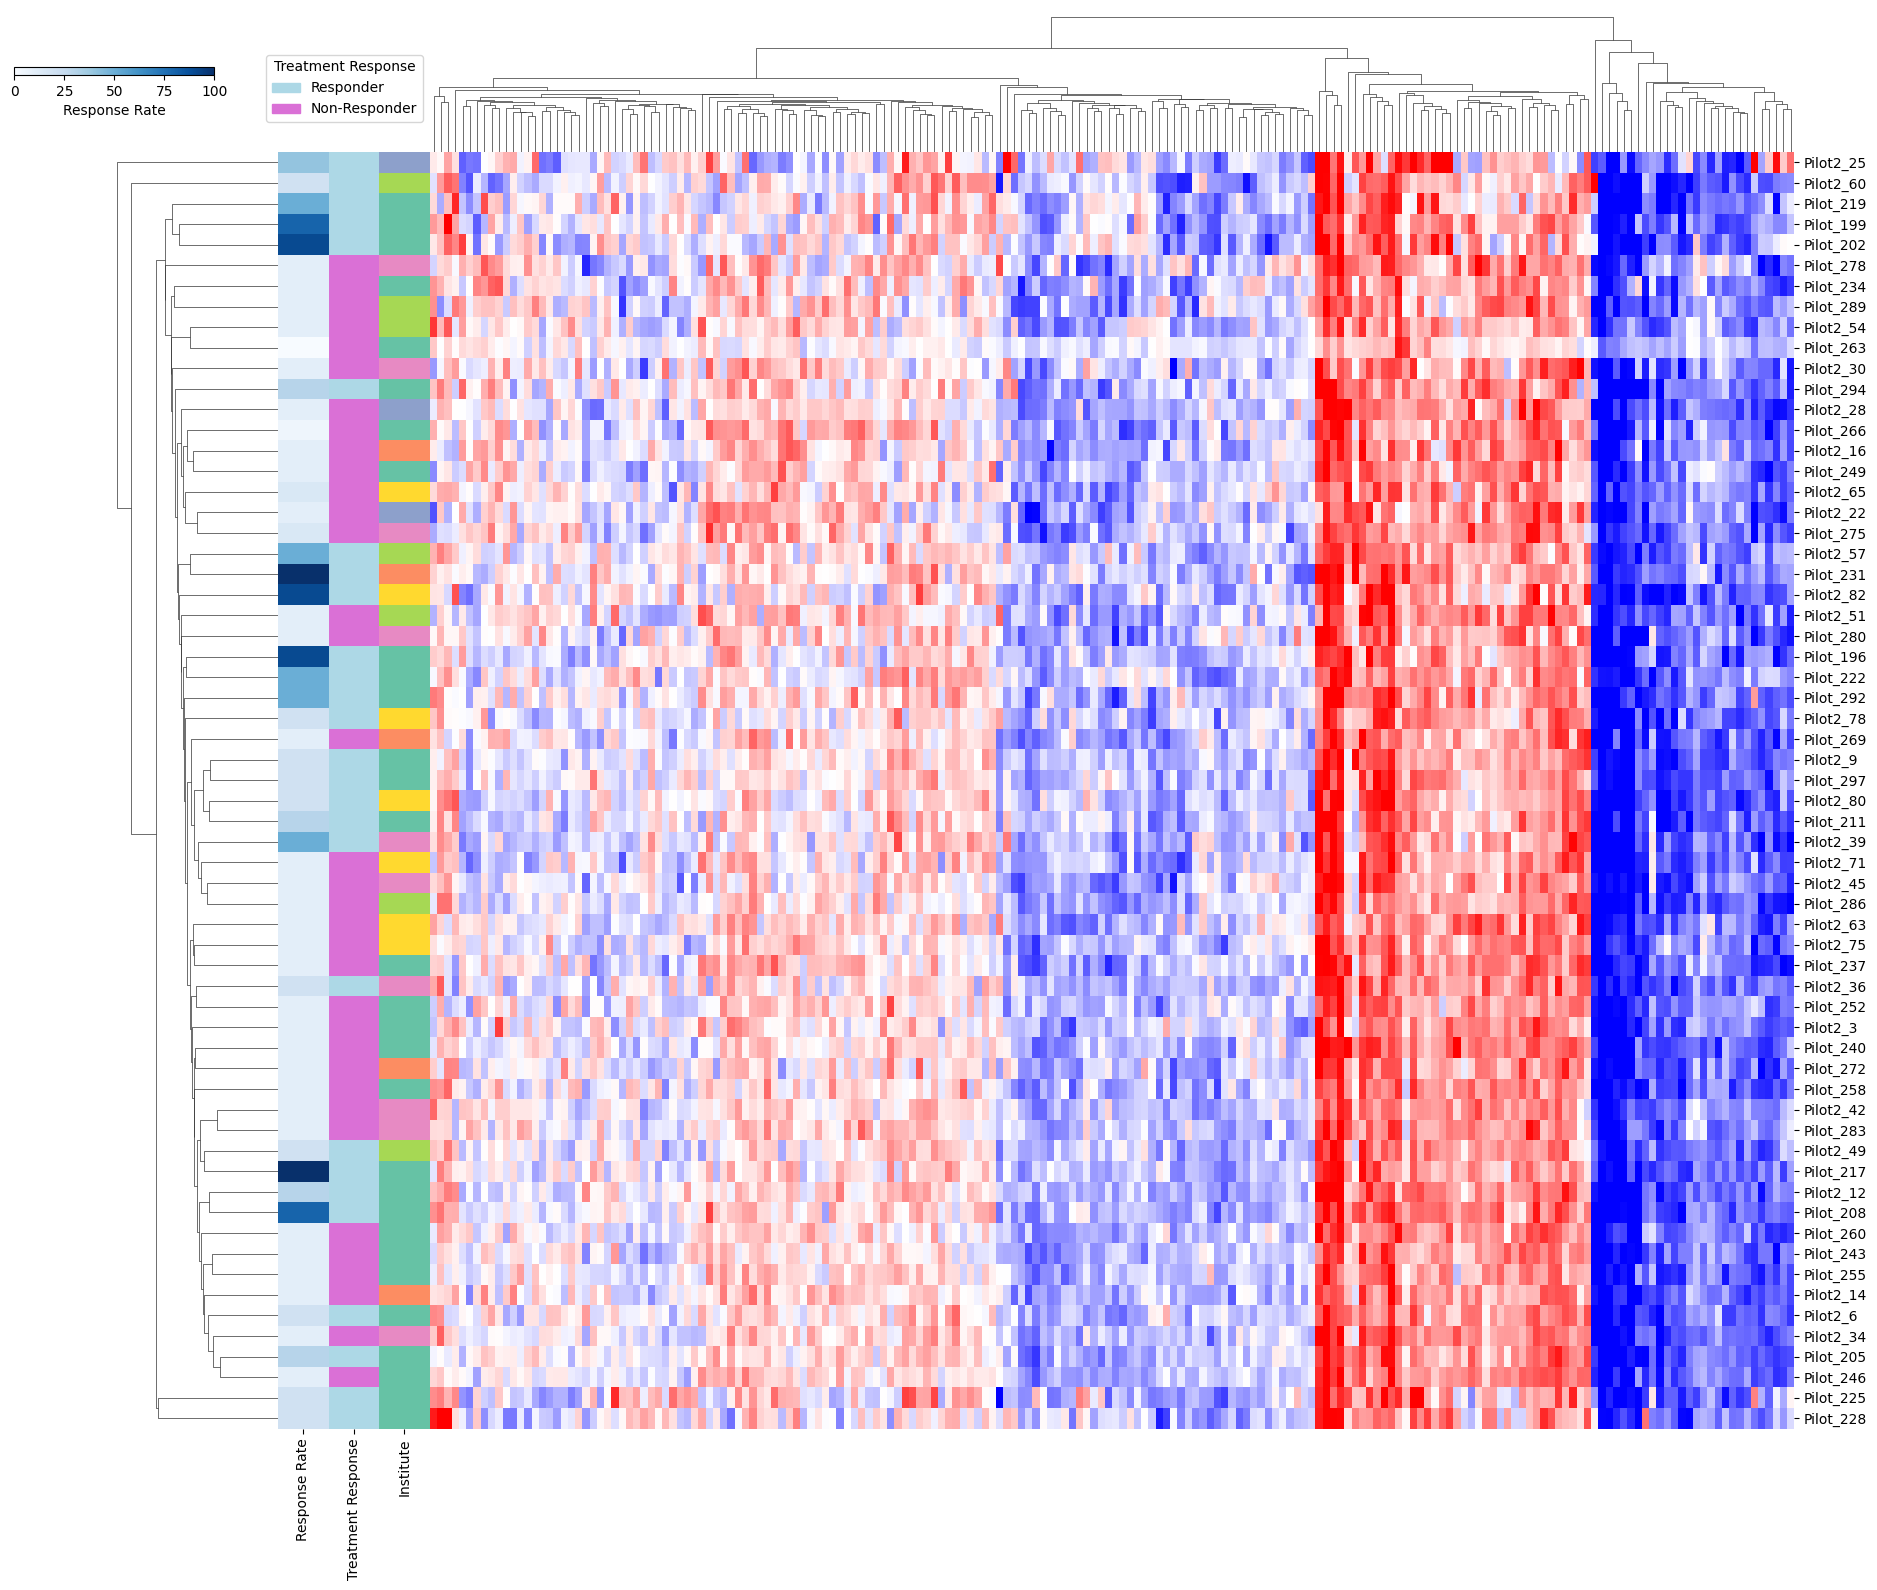

In [12]:
plot_clustered_heatmap(SCREEN_DATA, '/projects/b1198/epifluidlab/ravi/0130/headneck/notebooks/figures/coverage/screen_heatmap.png')

In [13]:
DAY0_PATH = '/projects/b1198/epifluidlab/ravi/0130/headneck/notebooks/figures/coverage/cov_day0.tsv'
DAY0_DATA = hc_data.get_subset(hc_data.day0_ids, df=hc_data.filter_locations(DAY0_PATH))

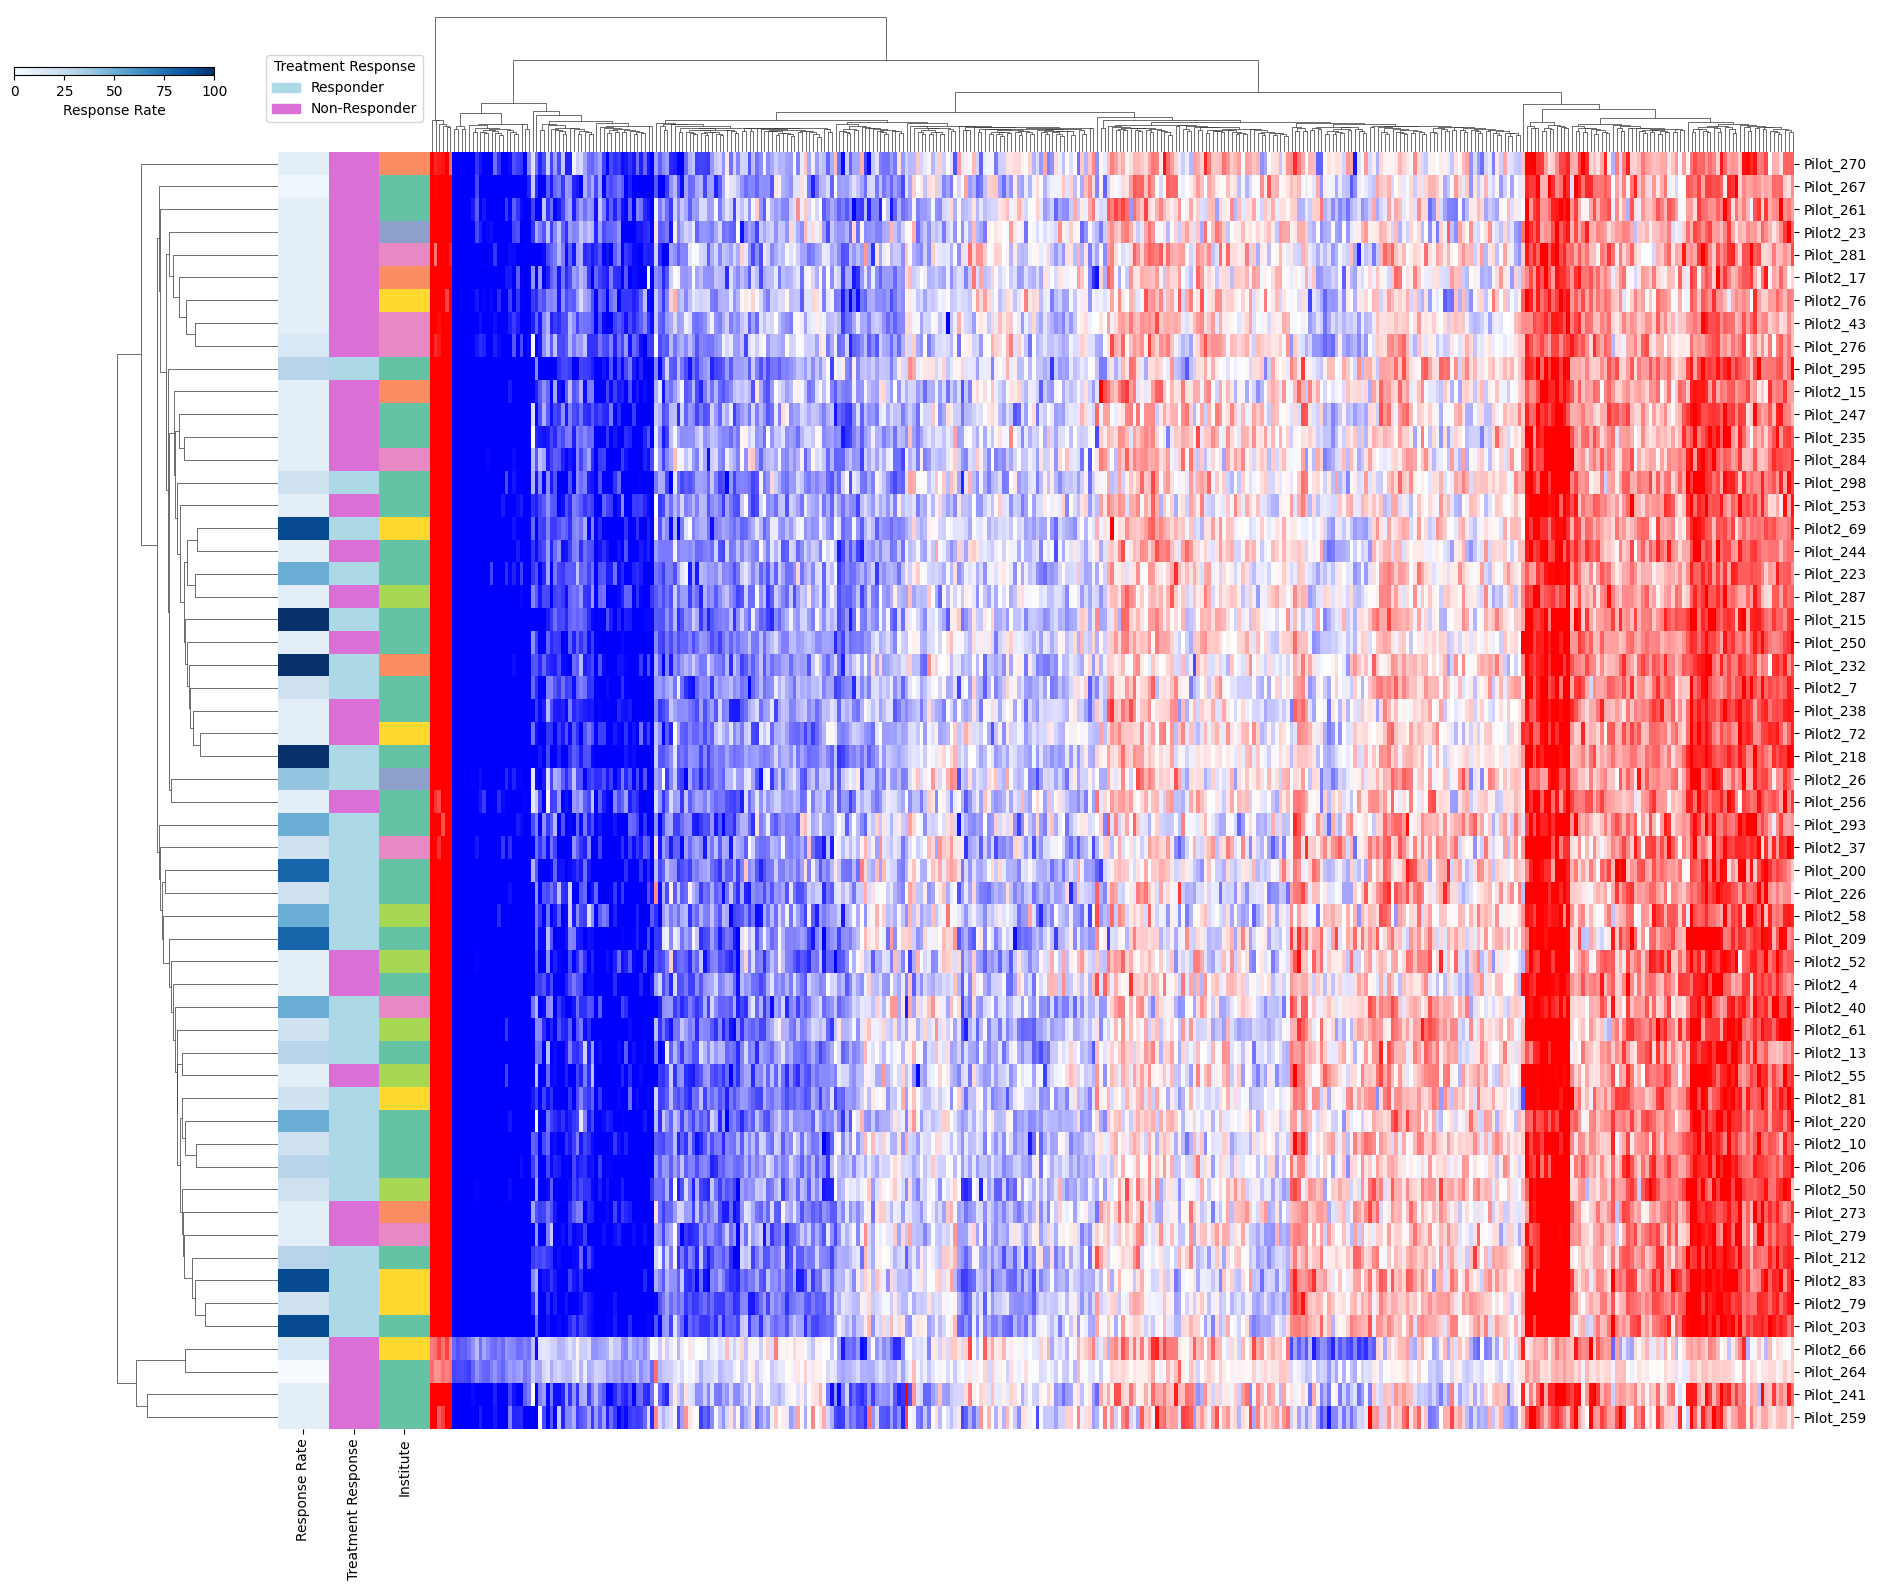

In [14]:
plot_clustered_heatmap(DAY0_DATA, '/projects/b1198/epifluidlab/ravi/0130/headneck/notebooks/figures/coverage/day0_heatmap.png')

In [15]:
ADJWK1_PATH = '/projects/b1198/epifluidlab/ravi/0130/headneck/notebooks/figures/coverage/cov_adjwk1.tsv'
ADJWK1_DATA = hc_data.get_subset(hc_data.adjwk1_ids, df=hc_data.filter_locations(ADJWK1_PATH))

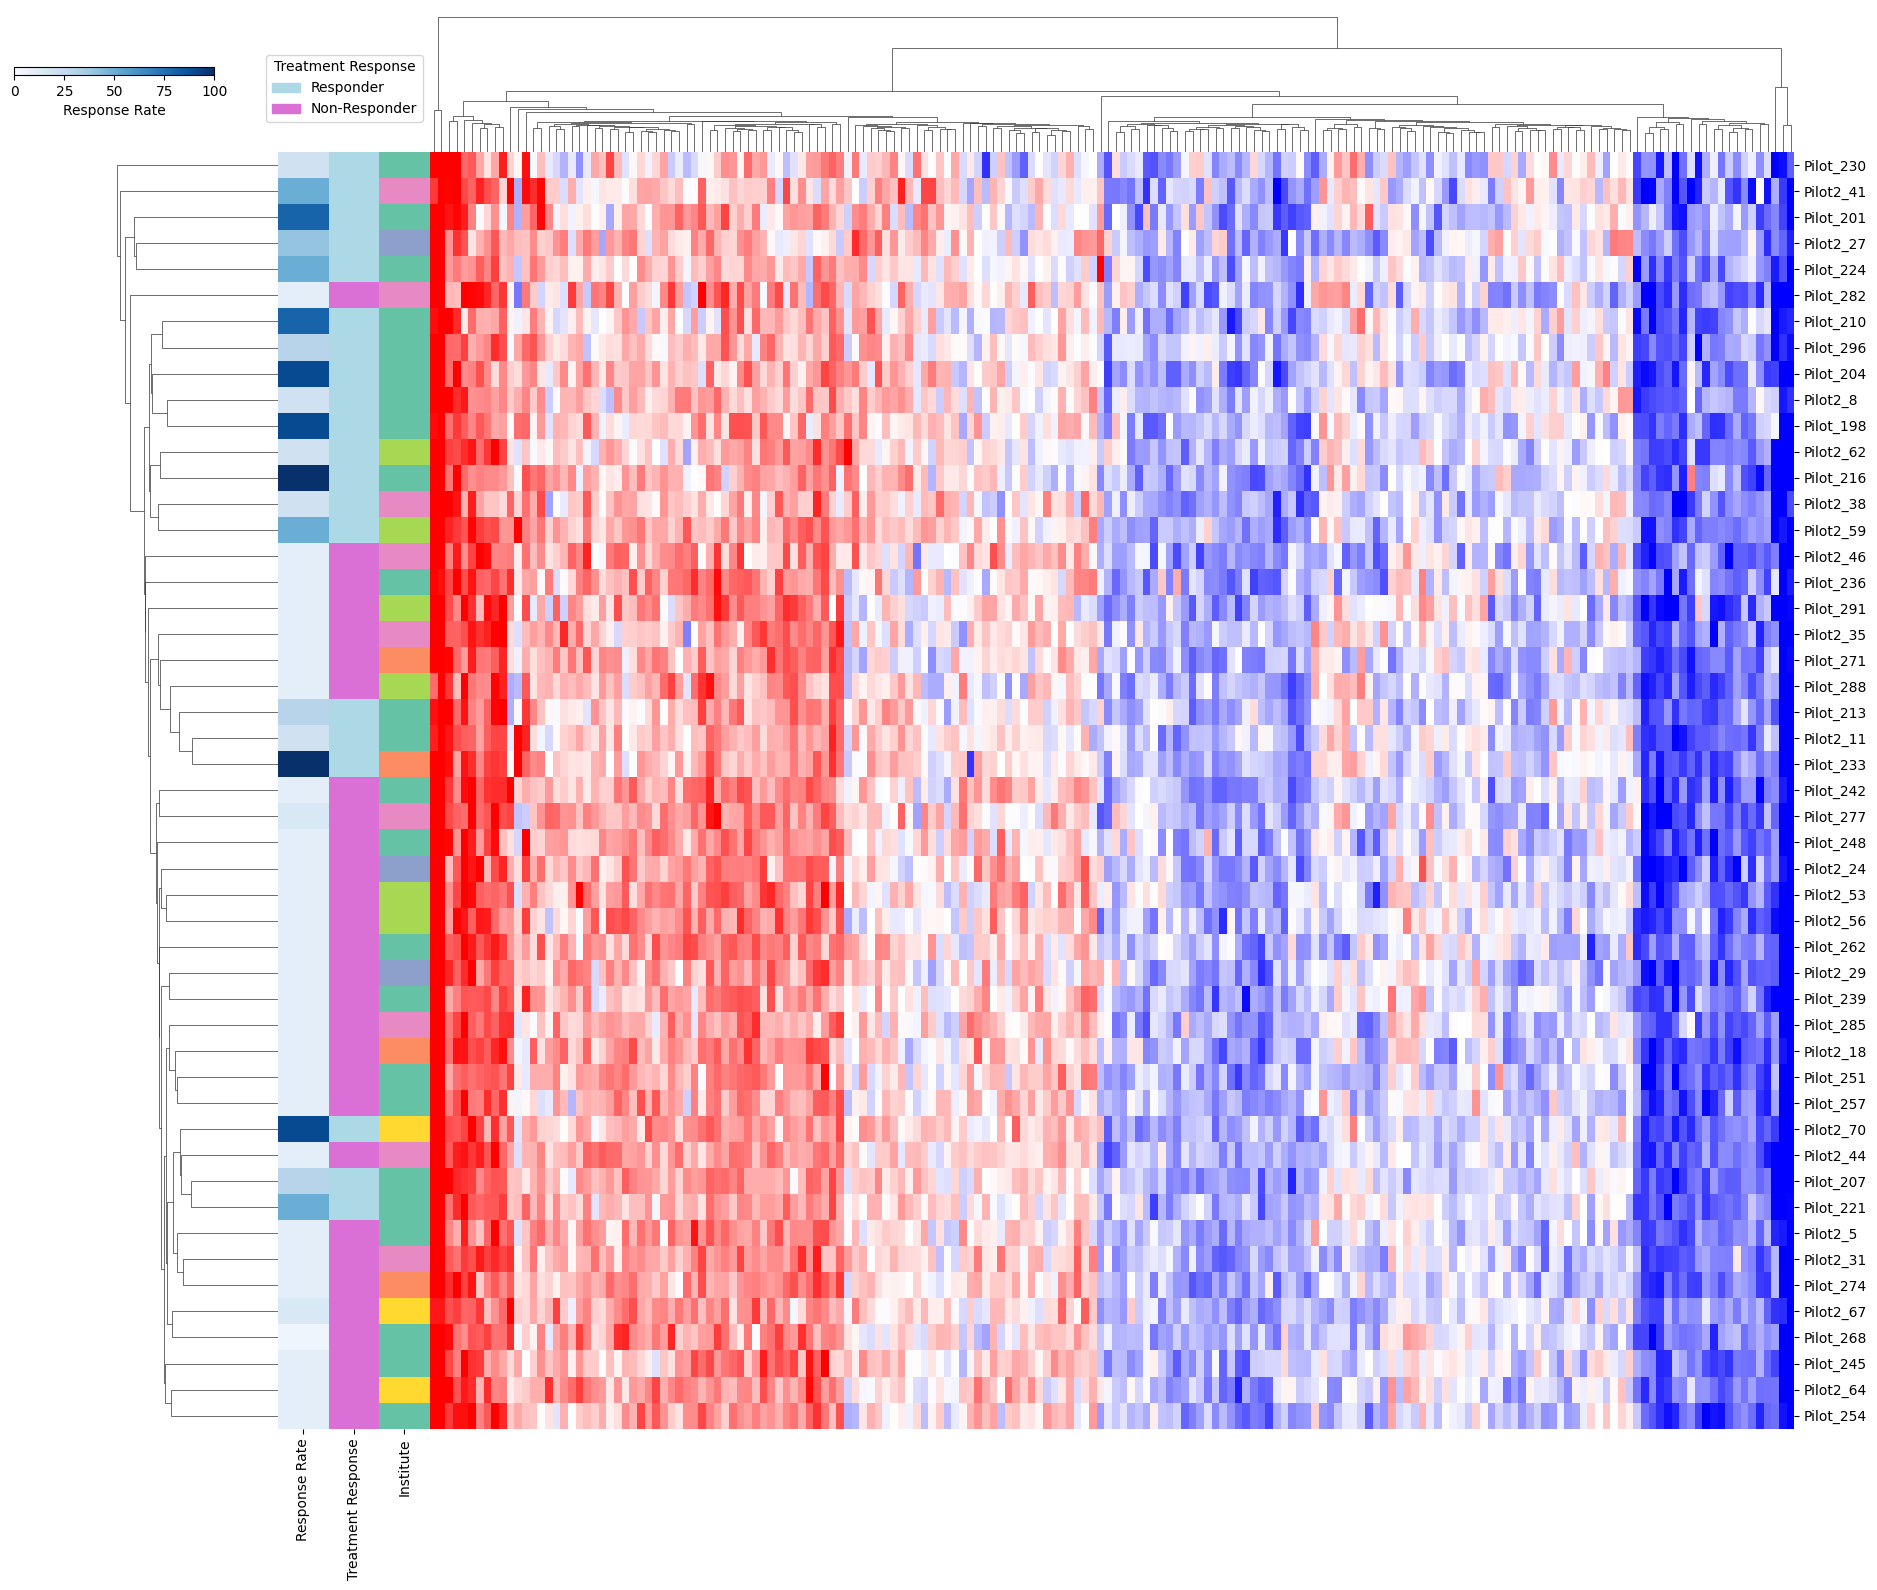

In [16]:
plot_clustered_heatmap(ADJWK1_DATA, '/projects/b1198/epifluidlab/ravi/0130/headneck/notebooks/figures/coverage/adjwk1_heatmap.png')